## Google Drive mounting and libraries imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install seqeval --quiet
!pip install tqdm --quiet
!pip install wandb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 22.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

import numpy as np
import pandas as pd

# The Gensim library is used to import and use word embedding models
import gensim
import gensim.downloader as api
from gensim.models import KeyedVectors

# The seqeval library contains utilities to evaluate the model's performances
from seqeval.scheme import IOB2
from seqeval.metrics import accuracy_score
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score

from tqdm import tqdm

# Weights and Biases is the service use to log and plot the history of the model's training
import wandb
import random

## Definition of parameters and hyperparameters

In [ ]:
# A list of different pre-trained embeddings to test
pretrained_embeddings = [
    'glove-wiki-gigaword-300',
    'word2vec-google-news-300',
    'glove-wiki-gigaword-200',
    'glove-twitter-200',
    'fasttext-wiki-news-subwords-300'
]

In [ ]:
# Definition of the parameters and hyperparameters 
parameters_dict = {
    'embed_dim':300, # the dimensionality of the word embeddings
    'hidden_dim':328, # By having a hidden dimensionality that is higher than the word embeddings, the LSTM can learn to capture more complex dependencies and relationships between the input sequence elements. This allows the model to better represent the input sequence and generate more accurate predictions.
    'num_epochs':30,
    'num_layers':1, # number of layers of the model
    'bidirectional':False,
    'batch_size':50,
    'dropout':0.5,
    'learning_rate':0.001,
    'pad_token':'<PAD>',
    'embedding_model':pretrained_embeddings[0], # selects which embeddings to use
    'run_name':'GRU_glove_300_1-layer_dr-0.5', # this name will be used to identify the model both in the W&B logs and the saved state_dict
    'debug_mode':False, # if False, logs the model's performances to W&B and saves the best model
    'lowercase':True # Transforms all the words of the dataset to lowercase
}

## Weights and Biases run initialization

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project='MNLP_Homework1_LSTM',
    name = parameters_dict['run_name'],
    # track hyperparameters and run metadata
    config=parameters_dict
)

## Preparing the dataset

In [ ]:
# Importing datasets using pandas
train_df = pd.read_json('/content/drive/MyDrive/mnlp_homework1/datasets/train.jsonl', lines=True)
dev_df = pd.read_json('/content/drive/MyDrive/mnlp_homework1/datasets/dev.jsonl', lines=True)
test_df = pd.read_json('/content/drive/MyDrive/mnlp_homework1/datasets/test.jsonl', lines=True)

In [ ]:
# Reading the tokens and labels for each dataset
train_tokens = train_df.tokens
train_labels = train_df.labels

dev_tokens = dev_df.tokens
dev_labels = dev_df.labels

test_tokens = test_df.tokens
test_labels = test_df.labels

The below functions are the utilities that allow the processing of the data in order to be properly fed to the dataset class and processed by the model.

In [ ]:
def to_lower(sentences):
  '''
  Transforms each token to lowercase and returns a list of lists of tokens.
  Args:
    sentences: a list of lists of tokens, where each sublist is a sentence
  '''
  transformed_sentences = []
  for sentence in sentences:
    current_sentence = []
    for token in sentence:
      current_sentence.append(token.lower())
    transformed_sentences.append(current_sentence)
  return transformed_sentences

def build_labels_dict(labels, pad_token):
  '''
  Indexes each possible label to a dictionary, including the padding label.
  Args:
    labels: a lists of lists of labels
    pad_token: the padding token
  '''
  label2idx = {pad_token:0}
  count = 1
  for sentence in labels:
    for label in sentence:
      if label not in label2idx:
        label2idx[label] = count
        count += 1

  idx2label = {idx: label for label, idx in label2idx.items()}
  return label2idx, idx2label

def add_padding(tokens_list, labels_list, pad_token):
  '''
  Adds padding to each sentence and each label list corresponding to the sentence.
  The result will be a list of lists of sentences, 
  where each sentence will be as long as the longest sentence present.
  Args:
    tokens_list: a list of lists of tokens
    labels_list: a list of lists of labels
    pad_token: the padding token
  '''
  max_len = max(len(sentence) for sentence in tokens_list)

  padded_tokens = []

  for tokens in tokens_list:
    current_tokens = tokens + [pad_token] * (max_len - len(tokens))
    padded_tokens.append(current_tokens)

  padded_labels = []

  for labels in labels_list:
    current_labels = labels + [pad_token] * (max_len - len(labels))
    padded_labels.append(current_labels)

  return padded_tokens, padded_labels

def build_labels(labels_list, labels_dict):
  '''
  Used the labels dictionary to transform each label from a string
  to its corresponding index.
  Args:
    labels_list: a lists of lists of labels (each label is a string)
    labels_dict: a dictionary that indexes each label
  '''
  output_labels = []

  for sentence in labels_list:
    current_sentence = []
    for token in sentence:
      current_sentence.append(labels_dict[token])
    output_labels.append(current_sentence)
    
  return output_labels

def embed_tokens(sentences, embedding_model, pad_token, embed_dim):
    '''
    Creates the word embeddings for each token. The padding tokens are handeld by
    assigning a vector of zeros, while unknown tokens are assigned to a vector of 
    random numbers. Every vector has the same dimension of the embedding dimensionality 
    of the embedding model.
    Args:
      sentences: a list of list of tokens
      embedding_model: a word embedding model
      pad_token: the padding token
      embed_dim: the dimensionality of the embeddings
    '''
    embedded_output = []
    pad_embedding = np.zeros(embed_dim)
    unknown_embedding = np.random.rand(embed_dim)
    
    # create a matrix of embeddings for all tokens in the sentences
    embeddings_matrix = np.zeros((len(embedding_model.index_to_key), embed_dim))
    for i, token in enumerate(embedding_model.index_to_key):
        embeddings_matrix[i] = embedding_model[token]

    # create an index for each token in the embeddings matrix
    index = {}
    for i, token in enumerate(embedding_model.key_to_index):
        index[token] = i

    # loop through each sentence and get the embeddings for each token
    for sentence in sentences:
        embedded_sentence = []
        for token in sentence:
            if token in index:
                embedded_sentence.append(embeddings_matrix[index[token]])
            elif token == pad_token:
                embedded_sentence.append(pad_embedding)
            else:
                embedded_sentence.append(unknown_embedding)
        embedded_output.append(embedded_sentence)
    
    return embedded_output

In [ ]:
def prepare_data(tokens, labels, parameters_dict, label2idx):
  '''
  Prepares the raw data in order to be fed to the dataset class. Uses the utilities
  functions defined above.
  Args:
    tokens: the raw list of lists of tokens
    labels: the raw list of lists of labels
    parameters_dict: the dictionary containing params and hparams
    label2idx: the dictionary that maps labels to indices
  '''
  pad_token = parameters_dict['pad_token']
  embed_dim = parameters_dict['embed_dim']

  tokens = to_lower(tokens)
  padded_tokens, padded_labels = add_padding(tokens, labels, pad_token)
  embedded_tokens = embed_tokens(padded_tokens, embedding_model, pad_token, embed_dim)
  indexed_labels = build_labels(padded_labels, label2idx)

  return embedded_tokens, indexed_labels

## Word embeddings model loading

In order to avoid downloading each time the model, use the api.load function just the first time, and save the embedding model on gdrive. This way the stored embedding models will be loaded straight form gdrive using the KeyedVector.load function.

In [ ]:
embedding_model  = api.load(parameters_dict['embedding_model'])
embedding_model.save("/content/drive/MyDrive/mnlp_homework1/glove-300.wordvectors")

[=================================================-] 99.8% 956.4/958.4MB downloaded


In [ ]:
embedding_model = KeyedVectors.load("/content/drive/MyDrive/mnlp_homework1/glove-300.wordvectors")

## Loading the dataset

The TaggingDataset class stores the processed tokens and labels. The redefinition of the \_\_getitem\_\_ function returns the tensor corresponding to each x and y indexed by the batch.

In [ ]:
class TaggingDataset(torch.utils.data.Dataset):
  def __init__(self, tokens, labels):
    self.tokens = tokens
    self.labels = labels

  def __getitem__(self, index):
    x = torch.FloatTensor(np.array(self.tokens[index]))
    y = torch.tensor(np.array(self.labels[index]))
    return x,y
  
  def __len__(self):
    return len(self.tokens)

The label2idx and idx2label are fixed for consistency.

In [ ]:
label2idx = {
    '<PAD>': 0,
    'O': 1,
    'B-SCENARIO': 2,
    'B-CHANGE': 3,
    'B-ACTION': 4,
    'B-SENTIMENT': 5,
    'I-CHANGE': 6,
    'B-POSSESSION': 7,
    'I-ACTION': 8,
    'I-SENTIMENT': 9,
    'I-SCENARIO': 10,
    'I-POSSESSION': 11
}

idx2label = {
    0: '<PAD>',
    1: 'O',
    2: 'B-SCENARIO',
    3: 'B-CHANGE',
    4: 'B-ACTION',
    5: 'B-SENTIMENT',
    6: 'I-CHANGE',
    7: 'B-POSSESSION',
    8: 'I-ACTION',
    9: 'I-SENTIMENT',
    10: 'I-SCENARIO',
    11: 'I-POSSESSION'
}

In [ ]:
# Processing of the raw data
train_tokens_embedded, train_indexed_labels  = prepare_data(train_tokens, train_labels, parameters_dict, label2idx)

dev_tokens_embedded, dev_indexed_labels = prepare_data(dev_tokens, dev_labels, parameters_dict, label2idx)

test_tokens_embedded, test_indexed_labels = prepare_data(test_tokens, test_labels, parameters_dict, label2idx)

In [ ]:
# Creation of the dataset and dataloaders
train_dataset = TaggingDataset(train_tokens_embedded, train_indexed_labels)
train_loader = DataLoader(train_dataset, batch_size=parameters_dict['batch_size'], shuffle=True)

dev_dataset = TaggingDataset(dev_tokens_embedded, dev_indexed_labels)
dev_loader = DataLoader(dev_dataset, batch_size=parameters_dict['batch_size'], shuffle=False)

test_dataset = TaggingDataset(test_tokens_embedded, test_indexed_labels)
test_loader = DataLoader(test_dataset, batch_size=parameters_dict['batch_size'], shuffle=False)

## Model definition

LSTM (Long Short-Term Memory) networks are a type of recurrent neural network (RNN) that can capture long-term dependencies in sequential data. An LSTM unit is composed of a cell state, input gate, forget gate, and output gate. The cell state represents the memory of the LSTM, which can be modified by the gates, that regulate what information to remember or to forget.


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, embed_dim, hidden_size, output_size, bidirectional, num_layers,dropout=0.2):
      '''
      This model implements and LSTM whose output is fed to a fully connected layer (after applying dropout)
      in order to output the logits corresponding to the probabilities for each label.
      If bidirectional is True, the hidden size of the LSTM is doubled before being fed to the fc layer.
      '''
      super(LSTMModel, self).__init__()

      self.lstm = nn.LSTM(embed_dim, hidden_size, batch_first=True, num_layers=num_layers,bidirectional=bidirectional)
      self.dropout = nn.Dropout(dropout)

      self.fc = nn.Linear(hidden_size*2 if bidirectional else hidden_size, output_size)

    def forward(self, x):
      lstm_output, _ = self.lstm(x)
      lstm_output = self.dropout(lstm_output)
      labels_logits = self.fc(lstm_output)

      return labels_logits

Gated Recurrent Unit (GRU) networks are a type of RNN that were born to solve the vanishing gradient problem, which is a typical flaw of classic RNNs. GRUs are based on the reset and update gate which directly affect their hidden state to determine how much of the previous hidden state and how much of the new input to incorporate into the new hidden state.

In [ ]:
class GRUModel(nn.Module):
  '''
  This model implements and GRU whose output is fed to a fully connected layer (after applying dropout)
  in order to output the logits corresponding to the probabilities for each label.
  If bidirectional is True, the hidden size of the GRU is doubled before being fed to the fc layer.
  '''
  def __init__(self, embed_dim, hidden_size, output_size, bidirectional, num_layers,dropout=0.2):
      super(GRUModel, self).__init__()

      self.gru = nn.GRU(embed_dim, hidden_size, batch_first=True, num_layers=num_layers,bidirectional=bidirectional)
      self.dropout = nn.Dropout(dropout)

      self.fc = nn.Linear(hidden_size*2 if bidirectional else hidden_size, output_size)

  def forward(self, x):
      gru_output, _ = self.gru(x)
      gru_output = self.dropout(gru_output)
      tagged_output = self.fc(gru_output)

      return tagged_output

## Training loop

Definition of the trainer class. This class will handle the training and the evaluation loop.

In [ ]:
class Trainer():
  '''
  The trainer class handles the training and evaluation loops by implementing the 
  train and evaluate model functions.
  '''
  def __init__(self, model, criterion, optimizer, label2idx, idx2label, parameters_dict, device):
    '''
    Args:
      model: the initialized model
      criterion: the loss criterion
      optimizer: the chosen optimizer
      label2idx: a dictionary that maps labels to indices
      idx2label: a dictionary that maps indices to labels
      parameters_dict: a dictionary containing params and hparams
      device: the device where to execute the training
    '''
    self.model = model
    self.criterion = criterion
    self.optimizer = optimizer
    self.label2idx = label2idx
    self.idx2label = idx2label
    self.parameters_dict = parameters_dict
    self.device = device
  
  def train(self, train_dataloader, val_dataloader):
    '''
    The main training loop. Trains the model for "num_epochs" epochs and keeps 
    track of the best_f1. If debug_mode is false, it also log the performances of 
    the model to W&B and saves the state dictionary of the model that scores the best f1.
    Args:
      train_dataloader: an initialized dataloader containing the training dataset
      val_dataloader: an initialized dataloader containing the evaluation dataset
    '''
    print(self.parameters_dict)
    epochs = self.parameters_dict['num_epochs']
    best_f1 = 0

    for epoch in range(epochs):
      train_loss, train_acc = 0.0, 0.0
      test_loss, test_acc = 0.0, 0.0

      num_batches = 0
      num_correct_train, total_train = 0, 0

      print(f'Epoch [{epoch+1}/{epochs}]')

      self.model.train()
      for x, y in tqdm(train_loader):
        epoch_loss = 0.0
        x, y = x.to(self.device), y.to(self.device)
        self.optimizer.zero_grad()
        
        output = self.model(x)
  
        # Compute training loss
        sample_loss = self.criterion(output.view(-1, output.shape[-1]), y.view(-1))
        sample_loss.backward()
        self.optimizer.step()

        train_loss += sample_loss.item()
        num_batches += 1

        # Compute training accuracy
        predictions = output.argmax(dim=-1)
        mask = y != self.label2idx['<PAD>']
        num_correct_train += (predictions[mask] == y[mask]).sum().item()
        total_train += mask.sum().item()

      avg_epoch_loss = train_loss / num_batches
      train_acc = num_correct_train / total_train

      # Evaluate model
      avg_val_loss, val_acc, f1 = self.evaluate_model(val_dataloader)



      print(f'Train loss: {avg_epoch_loss:.3f}, Train accuracy: {train_acc:.3f}')
      print(f'Validation f1 score: {f1:.3f}, Validation loss: {avg_val_loss:.3f}, Validation accuracy: {val_acc:.2f}')

      if not self.parameters_dict["debug_mode"]:
        if f1 > best_f1:
          print("Saving current best model")
          best_f1 = f1
          torch.save(model.state_dict(), '/content/drive/MyDrive/mnlp_homework1/best_model/'+ parameters_dict['run_name'] + '.pth')
        wandb.log({"Train Loss": avg_epoch_loss, "Train accuracy": train_acc, "Validation Loss": avg_val_loss, "Validation Accuracy": val_acc, "Validation F1": f1})

    if not self.parameters_dict["debug_mode"]:
      wandb.finish()

  def evaluate_model(self, val_dataloader):
    '''
    Evaluated the model on the validation dataset.
    Args:
      val_dataloader: an initialized dataloader containing the validation dataset.
    '''
    self.model.eval()
    y_true = []
    y_pred = []
    loss = 0.0
    acc = 0.0
    num_batches = 0
    num_correct, total = 0, 0

    with torch.no_grad():
      for x, y in tqdm(val_dataloader):
        x, y = x.to(self.device), y.to(self.device)
        output = self.model(x)
        transformed_output = output.view(-1, output.shape[-1])

        # Compute validation loss
        sample_loss = self.criterion(transformed_output, y.view(-1))
        loss += sample_loss.item()

        # Compute validation accuracy
        predictions = output.argmax(dim=-1)
        mask = y != self.label2idx['<PAD>']
        num_correct += (predictions[mask] == y[mask]).sum().item()
        total += mask.sum().item()

        num_batches += 1

        # Compute validation f1
        for i, seq in enumerate(predictions):
          # Mask padding values
          mask = y[i] != self.label2idx['<PAD>']
          y_true.append([self.idx2label[j.item()] for j in y[i][mask]])
          y_pred.append([self.idx2label[j.item()] if j.item() != self.label2idx['<PAD>'] else 'O' for j in seq[mask]])
          
    loss = loss / num_batches
    acc = num_correct / total
    f1 = f1_score(y_true, y_pred, average='macro',mode='strict',scheme=IOB2)
    
    return loss, acc, f1


Model, criterion and optimizer initialization.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GRUModel(parameters_dict['embed_dim'], parameters_dict['hidden_dim'], len(label2idx), parameters_dict['bidirectional'], parameters_dict['num_layers']).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=label2idx['<PAD>'])

optimizer = optim.Adam(model.parameters())

In [ ]:
trainer = Trainer(model, criterion, optimizer, label2idx, idx2label, parameters_dict, device)

In [ ]:
# Start training
trainer.train(train_loader, dev_loader)

{'embed_dim': 300, 'hidden_dim': 328, 'num_epochs': 30, 'num_layers': 1, 'bidirectional': False, 'batch_size': 50, 'dropout': 0.5, 'learning_rate': 0.001, 'pad_token': '<PAD>', 'embedding_model': 'glove-wiki-gigaword-300', 'run_name': 'lstm_glove_300_1-layer_dr-0.5', 'debug_mode': False, 'lowercase': True}
Epoch [1/30]


100%|██████████| 40/40 [00:03<00:00, 12.25it/s]


Train loss: 0.319, Train accuracy: 0.912
Validation f1 score: 0.446, Validation loss: 0.217, Validation accuracy: 0.93
Saving current best model
Epoch [2/30]


100%|██████████| 40/40 [00:02<00:00, 14.80it/s]


Train loss: 0.193, Train accuracy: 0.933
Validation f1 score: 0.574, Validation loss: 0.174, Validation accuracy: 0.94
Saving current best model
Epoch [3/30]


100%|██████████| 40/40 [00:02<00:00, 14.03it/s]


Train loss: 0.165, Train accuracy: 0.941
Validation f1 score: 0.611, Validation loss: 0.158, Validation accuracy: 0.94
Saving current best model
Epoch [4/30]


100%|██████████| 40/40 [00:03<00:00, 12.16it/s]


Train loss: 0.150, Train accuracy: 0.945
Validation f1 score: 0.648, Validation loss: 0.149, Validation accuracy: 0.94
Saving current best model
Epoch [5/30]


100%|██████████| 40/40 [00:03<00:00, 11.82it/s]


Train loss: 0.141, Train accuracy: 0.948
Validation f1 score: 0.665, Validation loss: 0.146, Validation accuracy: 0.94
Saving current best model
Epoch [6/30]


100%|██████████| 40/40 [00:02<00:00, 14.74it/s]


Train loss: 0.132, Train accuracy: 0.951
Validation f1 score: 0.635, Validation loss: 0.147, Validation accuracy: 0.94
Epoch [7/30]


100%|██████████| 40/40 [00:02<00:00, 14.72it/s]


Train loss: 0.125, Train accuracy: 0.953
Validation f1 score: 0.677, Validation loss: 0.147, Validation accuracy: 0.94
Saving current best model
Epoch [8/30]


100%|██████████| 40/40 [00:03<00:00, 12.83it/s]


Train loss: 0.117, Train accuracy: 0.955
Validation f1 score: 0.676, Validation loss: 0.145, Validation accuracy: 0.95
Epoch [9/30]


100%|██████████| 40/40 [00:03<00:00, 11.12it/s]


Train loss: 0.109, Train accuracy: 0.959
Validation f1 score: 0.670, Validation loss: 0.149, Validation accuracy: 0.94
Epoch [10/30]


100%|██████████| 40/40 [00:02<00:00, 15.00it/s]


Train loss: 0.102, Train accuracy: 0.961
Validation f1 score: 0.634, Validation loss: 0.154, Validation accuracy: 0.94
Epoch [11/30]


100%|██████████| 40/40 [00:02<00:00, 14.99it/s]


Train loss: 0.092, Train accuracy: 0.965
Validation f1 score: 0.663, Validation loss: 0.155, Validation accuracy: 0.95
Epoch [12/30]


100%|██████████| 40/40 [00:04<00:00,  9.70it/s]


Train loss: 0.083, Train accuracy: 0.969
Validation f1 score: 0.643, Validation loss: 0.165, Validation accuracy: 0.94
Epoch [13/30]


100%|██████████| 40/40 [00:03<00:00, 10.80it/s]


Train loss: 0.073, Train accuracy: 0.973
Validation f1 score: 0.645, Validation loss: 0.173, Validation accuracy: 0.94
Epoch [14/30]


100%|██████████| 40/40 [00:02<00:00, 13.57it/s]


Train loss: 0.064, Train accuracy: 0.976
Validation f1 score: 0.644, Validation loss: 0.183, Validation accuracy: 0.94
Epoch [15/30]


100%|██████████| 40/40 [00:02<00:00, 14.83it/s]


Train loss: 0.056, Train accuracy: 0.979
Validation f1 score: 0.635, Validation loss: 0.194, Validation accuracy: 0.94
Epoch [16/30]


100%|██████████| 40/40 [00:02<00:00, 14.47it/s]


Train loss: 0.049, Train accuracy: 0.982
Validation f1 score: 0.632, Validation loss: 0.206, Validation accuracy: 0.94
Epoch [17/30]


100%|██████████| 40/40 [00:03<00:00, 11.83it/s]


Train loss: 0.044, Train accuracy: 0.984
Validation f1 score: 0.633, Validation loss: 0.215, Validation accuracy: 0.94
Epoch [18/30]


100%|██████████| 40/40 [00:03<00:00, 11.28it/s]


Train loss: 0.040, Train accuracy: 0.986
Validation f1 score: 0.637, Validation loss: 0.229, Validation accuracy: 0.94
Epoch [19/30]


100%|██████████| 40/40 [00:02<00:00, 14.65it/s]


Train loss: 0.036, Train accuracy: 0.987
Validation f1 score: 0.624, Validation loss: 0.239, Validation accuracy: 0.94
Epoch [20/30]


100%|██████████| 40/40 [00:02<00:00, 14.52it/s]


Train loss: 0.033, Train accuracy: 0.988
Validation f1 score: 0.619, Validation loss: 0.248, Validation accuracy: 0.94
Epoch [21/30]


100%|██████████| 40/40 [00:03<00:00, 10.47it/s]


Train loss: 0.031, Train accuracy: 0.989
Validation f1 score: 0.618, Validation loss: 0.252, Validation accuracy: 0.94
Epoch [22/30]


100%|██████████| 40/40 [00:03<00:00, 11.68it/s]


Train loss: 0.029, Train accuracy: 0.990
Validation f1 score: 0.630, Validation loss: 0.260, Validation accuracy: 0.94
Epoch [23/30]


100%|██████████| 40/40 [00:03<00:00, 11.57it/s]


Train loss: 0.028, Train accuracy: 0.990
Validation f1 score: 0.624, Validation loss: 0.268, Validation accuracy: 0.94
Epoch [24/30]


100%|██████████| 40/40 [00:02<00:00, 14.41it/s]


Train loss: 0.027, Train accuracy: 0.990
Validation f1 score: 0.626, Validation loss: 0.270, Validation accuracy: 0.94
Epoch [25/30]


100%|██████████| 40/40 [00:02<00:00, 14.64it/s]


Train loss: 0.026, Train accuracy: 0.991
Validation f1 score: 0.617, Validation loss: 0.280, Validation accuracy: 0.94
Epoch [26/30]


100%|██████████| 40/40 [00:03<00:00, 12.15it/s]


Train loss: 0.025, Train accuracy: 0.991
Validation f1 score: 0.623, Validation loss: 0.284, Validation accuracy: 0.94
Epoch [27/30]


100%|██████████| 40/40 [00:03<00:00, 10.86it/s]


Train loss: 0.024, Train accuracy: 0.991
Validation f1 score: 0.612, Validation loss: 0.289, Validation accuracy: 0.94
Epoch [28/30]


100%|██████████| 40/40 [00:02<00:00, 14.23it/s]


Train loss: 0.023, Train accuracy: 0.992
Validation f1 score: 0.623, Validation loss: 0.286, Validation accuracy: 0.94
Epoch [29/30]


100%|██████████| 40/40 [00:02<00:00, 14.80it/s]


Train loss: 0.023, Train accuracy: 0.992
Validation f1 score: 0.621, Validation loss: 0.295, Validation accuracy: 0.94
Epoch [30/30]


100%|██████████| 40/40 [00:02<00:00, 14.74it/s]


Train loss: 0.023, Train accuracy: 0.992
Validation f1 score: 0.619, Validation loss: 0.296, Validation accuracy: 0.94


Train Loss,█▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train accuracy,▁▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇████████████
Validation Accuracy,▁▅▇▇███████▇▇▇▇▆▇▆▆▆▆▆▆▆▆▆▆▆▆▆
Validation F1,▁▅▆▇█▇███▇█▇▇▇▇▇▇▇▆▆▆▇▆▆▆▆▆▆▆▆
Validation Loss,▄▂▂▁▁▁▁▁▁▁▁▂▂▃▃▄▄▅▅▆▆▆▇▇▇▇████
Train Loss,0.02268
Train accuracy,0.99184
Validation Accuracy,0.93905
Validation F1,0.61885
Validation Loss,0.29557


## Model testing
Once the training is finished, it's now time to test it and make observation on its performances.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
embedding_model = KeyedVectors.load("/content/drive/MyDrive/mnlp_homework1/glove-300.wordvectors")

In [ ]:
test_parameters = {
    "embed_dim":300,
    "hidden_size":328,
    "output_size":12,
    "bidirectional":True,
    "num_layers":5,
    "dropout":0.2
}

In [ ]:
model = LSTMModel(test_parameters["embed_dim"], test_parameters["hidden_size"], test_parameters["output_size"], test_parameters["bidirectional"], test_parameters["num_layers"],test_parameters["dropout"]).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/mnlp_homework1/best_model/lstm_BI_glove-300_5-layers.pth",map_location=torch.device(device))) 
model.eval()

LSTMModel(
  (lstm): LSTM(300, 328, num_layers=5, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=656, out_features=12, bias=True)
)

In [ ]:
# Print the number of parameters of the models
model_num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"The model has {model_num_params} parameters.")

The model has 12010060 parameters.


In [ ]:
def add_padding_test(tokens_list,pad_token):
  '''
  Adds padding to each sentence and each label list corresponding to the sentence.
  The result will be a list of lists of sentences, 
  where each sentence will be as long as the longest sentence present.
  Args:
    tokens_list: a list of lists of tokens
    pad_token: the padding token
  '''
  max_len = max(len(sentence) for sentence in tokens_list)

  padded_tokens = []

  for tokens in tokens_list:
    current_tokens = tokens + [pad_token] * (max_len - len(tokens))
    padded_tokens.append(current_tokens)

  return padded_tokens

def create_predictions(model, embedded_sentences, padded_sentences, idx2label, label2idx):
    y_pred = []
    output = model(embedded_sentences)
    predictions = output.argmax(dim=-1)

    for i, seq in enumerate(predictions):
        # Mask padding values
        mask = [token != '<PAD>' for token in padded_sentences[i]]
        masked_indexes = [token for token, is_padding in zip(seq, mask) if is_padding]    
        masked_labels = [idx2label[idx.item()] for idx in masked_indexes]
        y_pred.append(masked_labels)
    return y_pred
        
def predict(model, sentences, pad_token, embedding_model, idx2label, label2idx):

    with torch.no_grad():
        lowered_sentences = to_lower(sentences)
        padded_sentences = add_padding_test(lowered_sentences, parameters_dict['pad_token'])
        embedded_sentences = torch.FloatTensor(embed_tokens(padded_sentences, embedding_model, parameters_dict['pad_token'], test_parameters['embed_dim'])).to(device)
        predictions = create_predictions(model, embedded_sentences, padded_sentences, idx2label, label2idx)
    
    return predictions

In [ ]:
x = test_df.tokens
y_true = test_df.labels

In [ ]:
y_pred = predict(model, x, parameters_dict['pad_token'], embedding_model, idx2label, label2idx)

###Computing seqeval f1 score and the classification report on the test set:

In [ ]:
f1 = f1_score(y_true, y_pred, average='macro', scheme=IOB2)
print(f"F1 SCORE: {f1:.2f}")

acc_score = accuracy_score(y_true, y_pred)
print(f'ACCURACY SCORE {acc_score:.3f}')

print("----- CLASSIFICATION REPORT ------")
print(classification_report(y_true, y_pred))

F1 SCORE: 0.71
ACCURACY SCORE 0.950
----- CLASSIFICATION REPORT ------
              precision    recall  f1-score   support

      ACTION       0.67      0.73      0.70      2257
      CHANGE       0.72      0.79      0.75      1303
  POSSESSION       0.78      0.70      0.74       275
    SCENARIO       0.68      0.69      0.68       629
   SENTIMENT       0.70      0.64      0.67       319

   micro avg       0.69      0.73      0.71      4783
   macro avg       0.71      0.71      0.71      4783
weighted avg       0.69      0.73      0.71      4783



###Plotting the confusion matrix on the test set

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import colorsys

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
  # Calculate the confusion matrix
  cm = confusion_matrix(np.concatenate(y_true), np.concatenate(y_pred), labels=labels)

  # Normalize the confusion matrix to percentages
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  # Set figure size
  fig, ax = plt.subplots(figsize=(10, 8))

  # Plot the confusion matrix as a heatmap
  im = ax.imshow(cm, cmap='Blues')

  # Add colorbar
  cbar = ax.figure.colorbar(im, ax=ax)

  # Set tick labels
  ax.set_xticks(np.arange(len(labels)))
  ax.set_yticks(np.arange(len(labels)))
  ax.set_xticklabels(labels, fontsize=10)
  ax.set_yticklabels(labels, fontsize=10)

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

  # Loop over data dimensions and create text annotations.
  for i in range(len(labels)):
      for j in range(len(labels)):
          # Set the text color to white for darker colors
          color = im.norm(cm[i, j])
          r, g, b, _ = im.cmap(color)
          brightness = colorsys.rgb_to_hsv(r, g, b)[2]
          text_color = "white" if brightness < 0.5 else "black"
          text = ax.text(j, i, f"{cm[i, j]:.2%}", ha="center", va="center", color=text_color, fontsize=8)

  # Add a title
  ax.set_title("Normalized Confusion Matrix")

  # Show the plot
  plt.show()

In [ ]:
labels = ['O','B-CHANGE','B-ACTION','B-SENTIMENT','I-CHANGE','B-POSSESSION','I-ACTION','I-SENTIMENT','I-SCENARIO','I-POSSESSION']

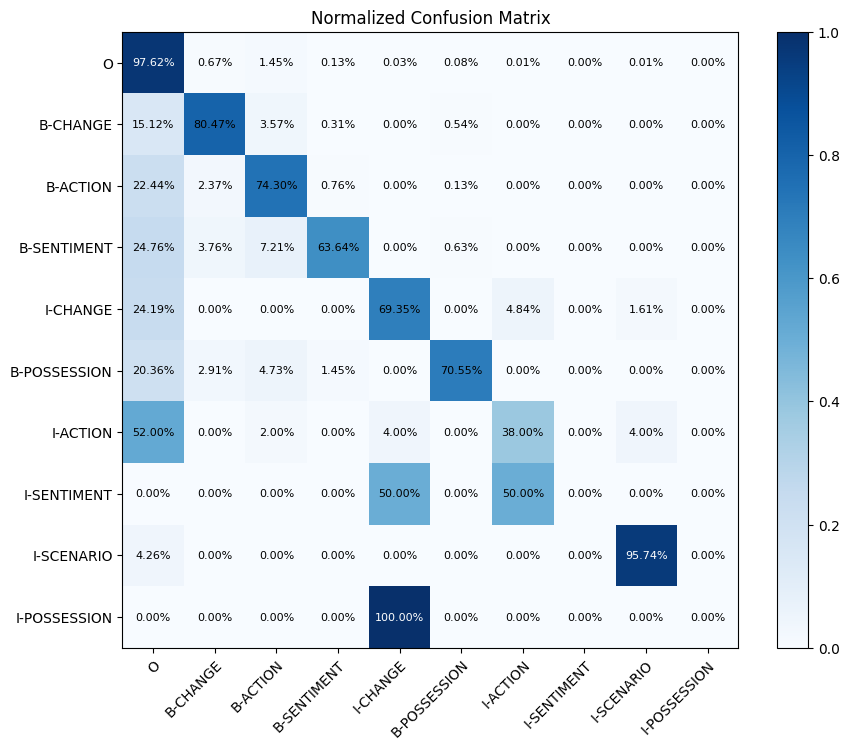

In [ ]:
plot_confusion_matrix(y_true, y_pred)